In [2]:
# Needs hdf5 to run
# Instead of hf datasets lib alternatively use torchgeo
# As of 02.11.24 failed to reach geo API, could attempt later
%pip install --upgrade torch;
%pip install --upgrade torchvision;
%pip install --upgrade datasets;
%pip install --upgrade h5py;
%pip install --upgrade kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.6 MB/s eta 0:00:00


In [16]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import sys
import torch
import datasets
import PIL
# from torchgeo.datasets import CaBuAr
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torchvision.transforms import functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt
from kornia import filters
import kornia.augmentation as K


# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@article{cabuar,
  title={Ca{B}u{A}r: California {B}urned {A}reas dataset for delineation},
  author={Rege Cambrin, Daniele and Colomba, Luca and Garza, Paolo},
  journal={IEEE Geoscience and Remote Sensing Magazine},
  doi={10.1109/MGRS.2023.3292467},
  year={2023}
}
"""

# You can copy an official description
_DESCRIPTION = """\
CaBuAr dataset contains images from Sentinel-2 satellites taken before and after a wildfire.
The ground truth masks are provided by the California Department of Forestry and Fire Protection and they are mapped on the images.
"""

_HOMEPAGE = "https://huggingface.co/datasets/DarthReca/california_burned_areas"

_LICENSE = "OPENRAIL"

# Define the root directory for the dataset
# Change manually


_URLS = {'root': os.curdir,'cache_dir':"raw"}
_BATCH_SIZE = 16
_NUM_WORKERS = 2
_TRAIN_SPLIT = 1
_VALID_SPLIT = 2
_TEST_SPLIT = 3


In [17]:
# Set the Hugging Face datasets cache directory
os.environ['HF_DATASETS_CACHE'] = os.path.join(_URLS['root'],_URLS['cache_dir'])
sys.path.append(os.path.abspath('..'))

# You can verify by printing (optional)
print(f"HF_DATASETS_CACHE set to: {os.getenv('HF_DATASETS_CACHE')}")

HF_DATASETS_CACHE set to: ./raw


In [23]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [24]:
# Load the CaBuAr dataset
# Possible splits: 1-5, or chabud
# For docs check out
# https://huggingface.co/datasets/DarthReca/california_burned_areas
# https://torchgeo.readthedocs.io/en/stable/api/datasets.html#cabuar
train_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_TRAIN_SPLIT}',trust_remote_code=True)
valid_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_VALID_SPLIT}',trust_remote_code=True)
test_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_TEST_SPLIT}',trust_remote_code=True)


TODO
 - Create an class ratio graphic in output mask

 - **(Optional)** showcase density of classes on mask (how noisy is the data)

 - Extract spectre distribution on random images

 - Mean brightness, distribution from center of inputs

 - how **correlated** are adjacent 2d tensors in pre-fire, post-fire, could dataset be ordered by **time** if needed?

## Dataset histogram per frequency layer

Important to know whether all layers are equally distributed on mean and variance

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


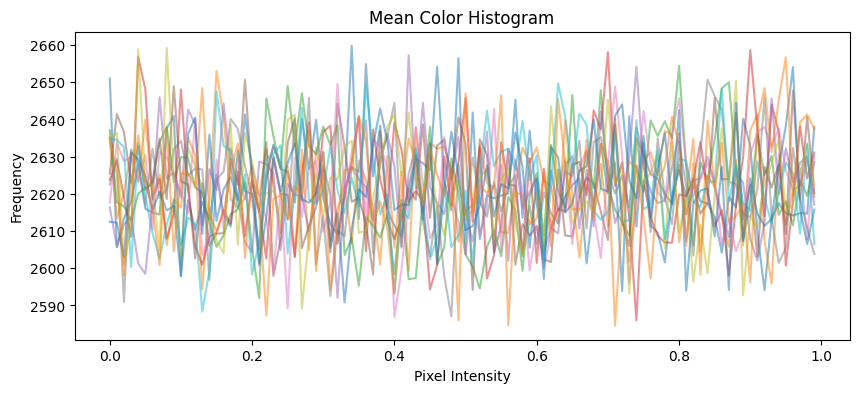

In [8]:
def calculate_histogram(image, bins=256):
    """
    Calculate histogram for each color channel of the image.

    Args:
        image (tensor): Image tensor of shape [C, H, W].
        bins (int): Number of bins for the histogram.

    Returns:
        hist (tensor): Histogram tensor of shape [C, bins].
    """
    hist = torch.zeros((image.size(0), bins))
    for c in range(image.size(0)):
        hist[c] = torch.histc(image[c], bins=bins, min=0, max=0)
    return hist
def mean_color_histogram(batch, bins=256):
    """
    Compute the mean color histogram for a batch of images.

    Args:
        batch (tensor): Batch of images of shape [B, C, H, W].
        bins (int): Number of bins for the histogram.

    Returns:
        mean_hist (tensor): Mean histogram tensor of shape [C, bins].
    """

    batch_size, channels, height, width = batch.size()
    histograms = torch.zeros((batch_size, channels, bins))

    for i in range(batch_size):
        histograms[i] = calculate_histogram(batch[i], bins=bins)

    mean_hist = histograms.mean(dim=0)
    return mean_hist
# Example batch of images with random values and specified size [batch_size, channels, height, width]
batch_size = _BATCH_SIZE
channels = 12
height = 512
width = 512

# Generate random images (for demonstration)
batch = torch.rand((batch_size, channels, height, width))

# Calculate mean color histogram
bins = 100
mean_hist = mean_color_histogram(batch, bins=bins)

# Plot the mean color histogram
def plot_histogram(histogram, bins):
    # colors = ['r', 'g', 'b']
    bin_edges = np.linspace(0, 1, bins + 1)

    plt.figure(figsize=(10, 4))
    for c in range(channels):
        print(histogram[c].size())
        # plt.plot(bin_edges[:-1], histogram[c].numpy(), color=colors[c], alpha=0.5)
        plt.plot(bin_edges[:-1], histogram[c].numpy(), alpha=0.5)
        #plt.hist(histogram[c].numpy(), bins=bins, alpha=0.5)


    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Mean Color Histogram')
    #plt.legend(['Red', 'Green', 'Blue'])
    plt.show()

plot_histogram(mean_hist, bins)

## Preprocessing functions



In [25]:
def compute_difference(pre_fire, post_fire):
    return post_fire - pre_fire

def hyperbolic_diff(img_x, img_y, scale = 0.5, bias = 0):
    if bias == -1e-6:
        bias = 0
    return scale * (img_x - img_y) / (img_x + img_y + bias + 1e-6)


def canny(image, lo=0.1, hi=0.2):
        return filters.canny(image, low_threshold=lo, high_threshold=hi)

def clip_values(image, min_val=0.0, max_val=1.0):
    return torch.clamp(image, min=min_val, max=max_val)

def unsharp(image):
    return filters.unsharp_maskkernel_size(image, (3, 3), sigma=(0.1, 2.0), border_type='refect')

def rearrange_channels(pre_fire, post_fire):
    # Stack pre-fire and post-fire channels
    return torch.cat([pre_fire, post_fire], dim=1)  # Shape: [Batch, 24, H, W]

In [213]:
mozaic = K.RandomJigsaw((2, 2), keepdim=True, p=0.25)
# TODO replace with a 3 channel united normalization
normalize = transforms.Normalize(mean=[0.485]*1, std=[0.229]*1)

gaussian_blur = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
adjust_contrast = transforms.ColorJitter(contrast=1.5)

totensor = transforms.Compose([
            transforms.Lambda(np.array), # List converts to numpy array
            transforms.ToTensor(),
        ])

transform = transforms.Compose([
    #transforms.Lambda(np.array), # List converts to numpy array
    mozaic,
    transforms.RandomAffine(degrees=15., translate=(0.3, 0.3), interpolation=PIL.Image.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #filters.Laplacian(kernel_size=(3, 3), border_type='reflect'),
])

augmentation = transforms.Compose([
    normalize,
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    # filters.Laplacian(kernel_size=(3, 3), border_type='reflect'),
    K.RandomGaussianNoise(std=0.2,  p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
])



## Feature detectors

-Important to denoise the data,
compute **low** and **high** pass filters, using gaussian and laplacian blur pyramids

- quantile tresholding to find peaks

- Sebile kernel filter
### Detect edges using derivative filters, canny edge detectors and hysteresis tresholding for edges

### Define scripts to convert image to 3 channel image
### Define purging clipping of class values
### Normalization
### Showing before/after
### Resizing of images (Optional)

### Three channels
## Fire intensity
## Cloud cover
## Difference layer
## Or (Red, NRI, Combined cloud cover/Water vapor)

In [214]:
# Define a custom PyTorch Dataset to apply transformations
class CaBuArPyTorchDataset(datasets.GeneratorBasedBuilder):
    def __init__(self, hf_dataset, transform=None, augment=None):
    # Commented - Alternative def using torchgeo parent class
    #def __init__(self, root, transform=None, download = False):
        """
        Args:
            hf_dataset: Hugging Face dataset object
            transform: Optional transform to be applied on a sample
            download: if True, download dataset and store it in the root directory
        """
        # super().__init__(root=root, transforms=transform, download=download)
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.augment = augment


    def calculate_ndvi(self, pre_fire, post_fire):
        # Assuming NIR is channel 8 and Red is channel 4 (0-indexed)
        # pre_nir = pre_fire[:, 7, :, :].unsqueeze(0)
        # pre_red = pre_fire[:, 3, :, :].unsqueeze(0)
        # post_nir = post_fire[:, 7, :, :].unsqueeze(0)
        # post_red = post_fire[:, 3, :, :].unsqueeze(0)
        pre_nir = pre_fire[:, 7, :, :]
        pre_red = pre_fire[:, 3, :, :]
        post_nir = post_fire[:, 7, :, :]
        post_red = post_fire[:, 3, :, :]
        # Compute hyperbolic difference of channels
        ndvi_pre = hyperbolic_diff(pre_nir, pre_red, scale=1.)
        ndvi_post = hyperbolic_diff(post_nir, post_red, scale=1.)

        # Return a mean square distance between old and new
        return torch.square(ndvi_post - ndvi_pre)


    def fire_boundary(self, post_fire, lo=0.1, hi=0.2):
        # Extract low frequency bands:
        # band_11 = post_fire[:, 10, :, :].unsqueeze(0)
        # band_12 = post_fire[:, 11, :, :].unsqueeze(0)
        band_11 = post_fire[:,10, :, :]
        band_12 = post_fire[:,11, :, :]

        return hyperbolic_diff(band_11, band_12, 8.5, 0.25)  # Shape: [B, 1, H, W]

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        post_fire = sample['post_fire']  # Shape: (512, 512, 12)
        mask = sample['mask']            # Shape: (512, 512, 1)
        pre_fire = sample.get('pre_fire', np.zeros_like(post_fire))

        # Convert list files into tensors
        pre_fire = totensor(pre_fire).unsqueeze(0)
        post_fire = totensor(post_fire).unsqueeze(0)
        mask = totensor(mask)

        # Calculate NDVI - natural vegetation index
        ndvi = self.calculate_ndvi(pre_fire, post_fire)

        # Compute fire boundary using sentinel script
        fire_boundary = self.fire_boundary(pre_fire, post_fire)

        # Extract water vapor band 09
        # water_vapor = post_fire[:, 8, :, :].unsqueeze(0)
        water_vapor = post_fire[:, 8, :, :].float()

        # Augment layers: edge detection, saturation etc.
        if self.augment:
            ndvi = self.augment(ndvi)
            water_vapor = self.augment(water_vapor)
            fire_boundary = self.augment(fire_boundary)

        # Prepare mask
        mask = mask.float()  # or long, depending on loss function

        # Concatenate pre-fire, post-fire, NDVI, difference
        combined_input = torch.cat([ndvi, water_vapor, fire_boundary, mask.unsqueeze(0)], dim=0)  # 4 channels]

        # Transform all layers uniformly, to maintain ground truth on validation
       # combined_input = combined_input.unsqueeze(0)  # Add batch dimension for transforms
        if self.transform:
            combined_input = self.transform(combined_input)
        combined_input = combined_input.squeeze(0)  # Remove batch dimension

        # Move tensors to device
        # combined_input = combined_input.to(device)
        # pre_fire = combined_input[:, :13, :, :]
        # post_fire = combined_input[:, 13:25, :, :]
        # mask = combined_input[: 25, :, :]
        # ndvi_pre = combined_input[:, 26, :, :]
        # ndvi_post = combined_input[:, 27, :, :]
        # diff_image = combined_input[:, 27:, :, :]




        # Prepare the X_input and y
        return combined_input[:-1], combined_input[-1]

In [175]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [215]:
# Instantiate the custom dataset
train_dataset = CaBuArPyTorchDataset(
    hf_dataset=train_data,
    transform=transform,
    augment=augmentation,
)
valid_dataset = CaBuArPyTorchDataset(
    hf_dataset=valid_data,
    transform=transform,
    augment=augmentation,
)
test_dataset = CaBuArPyTorchDataset(
    hf_dataset=test_data,
)
dataloader = WrappedDataLoader(DataLoader(
    train_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=True,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)

In [ ]:
%%time
# Example: Iterate through the DataLoader
for batch_idx, batch in enumerate(dataloader):
    X, y = batch

    # Now you can pass `post_fire`, `pre_fire`, and `mask` to your model
    # Example:
    # outputs = model(post_fire, pre_fire)
    # loss = criterion(outputs, mask)

    # For demonstration, we'll just print the batch shapes
    print(f"Batch {batch_idx}:")
    print(f"  post_fire shape: {X.shape}")
    # if pre_fire is not None:
    #     print(f"  pre_fire shape: {pre_fire.shape}")
    print(f"  mask shape: {y.shape}")

    # Break after first batch for demonstration
    if batch_idx == 0:
        break

In [216]:
X_train, y_train = next(enumerate(dataloader))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b18b07aa680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b18b07aa680>if w.is_alive():

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
AssertionError:     if w.is_alive():can only test a child process

  File "/usr/lib/

In [217]:
X_train, y = y_train

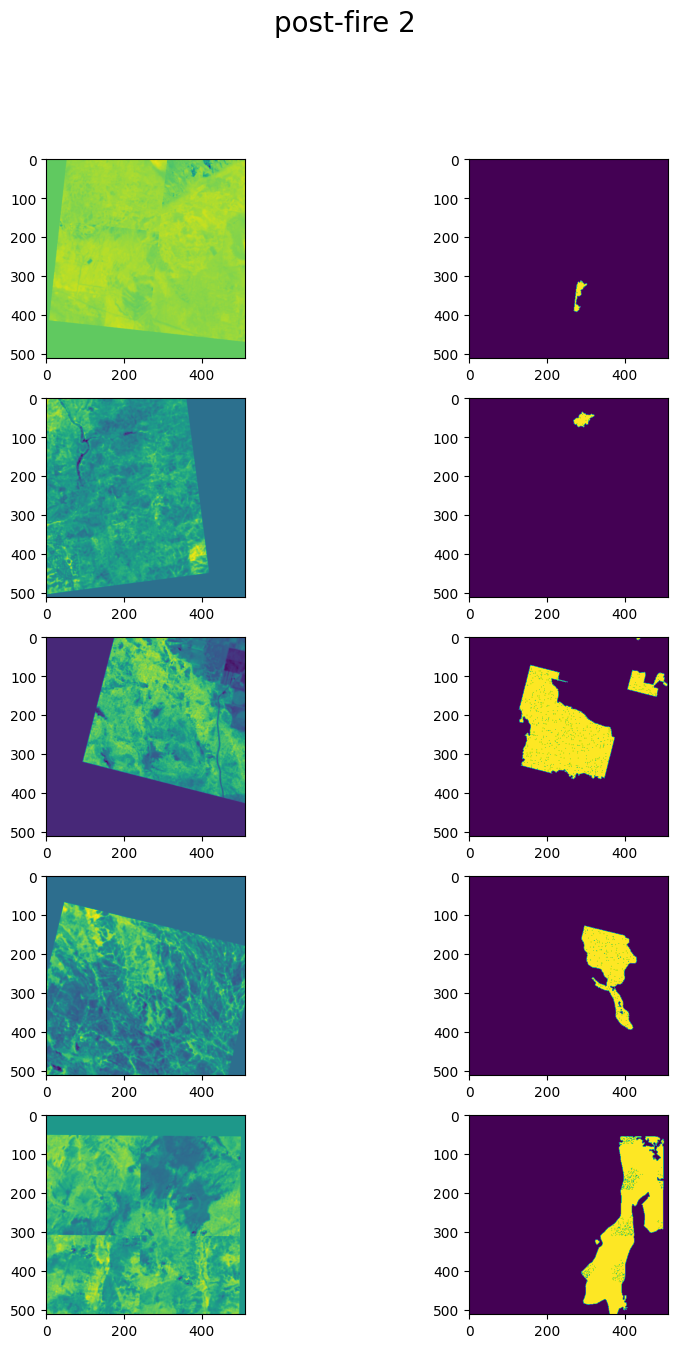

In [218]:

# Let's plot some images

fig, axes = plt.subplots(5, 2, figsize=(10,15))
ch = 2
fig.suptitle(f"post-fire {ch}", fontsize=20)
for i in range(5):
    axes[i,0].imshow(X_train[i+5,ch].view(512,512,1).numpy())
    axes[i,1].imshow(y[i+5].view(512,512,).numpy())
plt.show()
    #plt.title(str(y_train[i].item()))
#j = 0
# for cls in clss_counts.index:
#     cls_indices = np.where(y_train.numpy() == cls)[0]
#     if len(cls_indices) > 0:
#         plt.subplot(2, len(clss_counts), j + 1)
#         plt.axis('off')
#         plt.imshow(X_train[cls_indices[0], :, :, :].numpy().reshape(28, 28), cmap="gray_r")
#         plt.title(str(cls))
#         j += 1

# AlexNet + Clusterization

In [ ]:
from models import AlexNet
from models import KMeansClustering
model = AlexNet()
print(model)
class SemanticSegmentationNetwork(nn.Module):
    def __init__(self, num_clusters=6, input_channels=9, num_classes=6):
        super(SemanticSegmentationNetwork, self).__init__()
        self.feature_extractor = AlexNet(input_channels=input_channels)
        self.segmentation_head = KMeansClustering(num_clusters=num_clusters, num_features=256)

    def forward(self, pre_fire, post_fire, edge_image):
        combined_input = torch.cat((pre_fire, post_fire, edge_image), dim=1)
        print(f"convolution in shape: {combined_input.shape}")
        features = self.feature_extractor(combined_input)
        print(f"convolution out shape: {features.shape}")
        segmentation_mask = self.segmentation_head(features)
        return segmentation_mask

TODO
 - Create an class ratio graphic in output mask

 - **(Optional)** showcase density of classes on mask (how noisy is the data)

 - Extract spectre distribution on random images

 - Mean brightness, distribution from center of inputs

 - how **correlated** are adjacent 2d tensors in pre-fire, post-fire, could dataset be ordered by **time** if needed?

In [ ]:

#from models.semantic_segmentation import SemanticSegmentationNetwork

# Create dummy data
batch_size, height, width = 1, 224, 224
pre_fire = torch.randn(batch_size, 3, height, width)
post_fire = torch.randn(batch_size, 3, height, width)
edge_image = torch.randn(batch_size, 3, height, width)

# Initialize the network
model = SemanticSegmentationNetwork(num_clusters=6, input_channels=9)

# Forward pass
segmentation_mask = model(pre_fire, post_fire, edge_image)

# Print the output shape
print("Segmentation Mask Shape:", segmentation_mask.shape)

In [ ]:
# (Optional) Collect accuracy vector after training epochs
# Here, it's assumed you have a training loop where you collect accuracy

# Example training loop structure
def train_model(dataloader, model, criterion, optimizer, num_epochs=10):
    loss_vector = []
    accuracy_vector = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in dataloader:
            post_fire = batch['post_fire']
            mask = batch['mask']
            pre_fire = batch.get('pre_fire')

            # Move data to device
            post_fire = post_fire.to(device)
            mask = mask.to(device)
            if pre_fire is not None:
                pre_fire = pre_fire.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(post_fire, pre_fire) if pre_fire is not None else model(post_fire)
            loss = criterion(outputs, mask)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * post_fire.size(0)
            # Assuming outputs are logits; apply argmax to get predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == mask).sum().item()
            total += mask.numel()

        epoch_loss = running_loss / len(pytorch_dataset)
        epoch_acc = 100. * correct / total
        loss_vector.append(epoch_loss)
        accuracy_vector.append(epoch_acc)

        print(f"Epoch {epoch}/{num_epochs}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.2f}%")

    print("Training complete.")
    print("Accuracy vector:", accuracy_vector)
    return loss_vector, accuracy_vector